# Investigating verb generation data

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Set some plot defaults
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
import nibabel as nib

In [4]:
subj_dir = 'sub009'

In [5]:
bold_fname = os.path.join(subj_dir, 'BOLD/task002_run001/bold.nii.gz')
bold_img = nib.load(bold_fname)

In [6]:
bold_img.shape

(64, 64, 30, 173)

In [7]:
bold_data = bold_img.get_data()

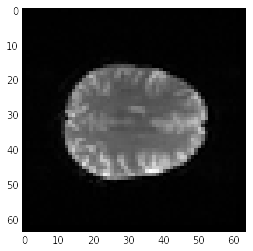

In [8]:
plt.imshow(bold_data[:, :, 17, 0])

In [9]:
cond_fname = subj_dir + '/model/model001/onsets/task002_run001/cond001.txt'
dtype_def = [('onset', 'f'), ('duration', 'f'), ('amplitude', 'f')]
evs = np.loadtxt(cond_fname, dtype_def)
evs

array([(10.0, 30.0, 1.0), (70.0, 30.0, 1.0), (130.0, 30.0, 1.0),
       (190.0, 30.0, 1.0), (250.0, 30.0, 1.0), (310.0, 30.0, 1.0),
       (370.0, 30.0, 1.0)], 
      dtype=[('onset', '<f4'), ('duration', '<f4'), ('amplitude', '<f4')])

In [10]:
print(bold_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : ?TR:2500.000 TE:50
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [  4  64  64  30 173   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          4.          4.          4.00001621  2.5         1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.9958999753
quatern_d       : -0.0904608666897
qoffset_x       : 124.2440032

## Time-courses

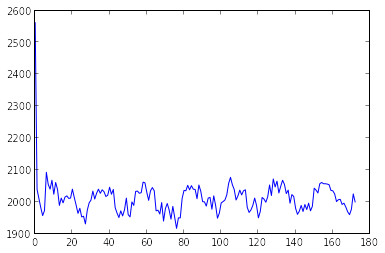

In [11]:
a_time_course = bold_data[43, 38, 17, :]
plt.plot(a_time_course)

## Different views on the data

In [12]:
shape_3d = bold_data.shape[:3]
shape_3d

(64, 64, 30)

In [13]:
vol_0 = bold_data[:, :, :, 0]
vol_1 = bold_data[:, :, :, 1]
vol_1.shape

(64, 64, 30)

In [14]:
n_voxels = np.prod(shape_3d)
n_vols = bold_data.shape[-1]
n_voxels, n_vols

(122880, 173)

In [15]:
voxels_by_time = bold_data.reshape((n_voxels, n_vols))
voxels_by_time.shape

(122880, 173)

In [16]:
time_by_voxels = voxels_by_time.transpose()
time_by_voxels.shape

(173, 122880)

In [17]:
back_again = time_by_voxels.transpose()
back_again = back_again.reshape(bold_data.shape)
np.all(back_again == bold_data)


True

## Straight to an analysis

In [18]:
TR = 2.5 # From the paper, and from header.pixdims[4]

In [19]:
evs['onset']

array([  10.,   70.,  130.,  190.,  250.,  310.,  370.], dtype=float32)

In [20]:
evs['onset'] /= TR
evs['duration'] /= TR

In [21]:
evs['onset']

array([   4.,   28.,   52.,   76.,  100.,  124.,  148.], dtype=float32)

In [22]:
evs['duration']

array([ 12.,  12.,  12.,  12.,  12.,  12.,  12.], dtype=float32)

In [23]:
starts = evs['onset']
ends = evs['onset'] + evs['duration']
n_vols = bold_img.shape[-1]
on_block = np.zeros(n_vols, dtype=bool)
indices = np.arange(n_vols)
for i in range(len(starts)):
    start = starts[i]
    end = ends[i]
    on_block[(indices >= start) & (indices <= end)] = 1
plt.plot(indices, on_block)

In [24]:
on_volumes = bold_data[:, :, :, on_block]
off_volumes = bold_data[:, :, :, on_block == False]
on_volumes.shape

(64, 64, 30, 91)

In [25]:
off_volumes.shape

(64, 64, 30, 82)

In [26]:
difference = on_volumes.mean(axis=3) - off_volumes.mean(axis=3)

In [27]:
on_volumes.mean(axis=3).shape

(64, 64, 30)

In [28]:
off_volumes.mean(axis=3).shape

(64, 64, 30)

In [29]:
time_course = on_volumes[43, 38, 17, :]
time_course.shape

(91,)

In [30]:
time_course.mean()

2027.9560439560439

In [31]:
on_volumes.mean(axis=3)[43, 38, 17]

2027.9560439560439

In [32]:
plt.imshow(difference[:, :, 17])

In [33]:
diff_img = nib.Nifti1Image(difference, bold_img.affine, bold_img.header)
nib.save(diff_img, 'difference.nii.gz')

In [34]:
overall_mean = bold_data.mean(axis=3)

In [35]:
flat_mean = overall_mean.reshape(n_voxels)

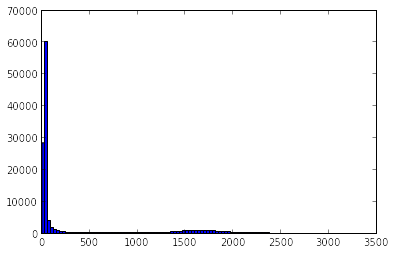

In [36]:
plt.hist(flat_mean, 100);

In [37]:
mean_across_voxels = time_by_voxels.mean(axis=1)

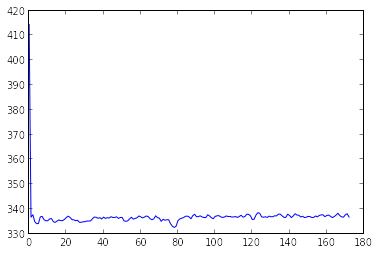

In [38]:
plt.plot(mean_across_voxels)